<a href="https://colab.research.google.com/github/everestial/TestSwitchErrors/blob/fix-scripts/Scripts/SwitchErrorTest_PhaseExtenderSetA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
dir.create("data")

In [14]:
download.file("https://raw.githubusercontent.com/everestial/TestSwitchErrors/fix-scripts/data/SetA/truth_Haplotype_NA12891.txt", destfile = "data/truth_Haplotype_NA12891.txt")

In [1]:
list.files()

AttributeError: type object 'list' has no attribute 'files'

In [22]:
truthHaplotype_NA12891 <- read.table('data/truth_Haplotype_NA12891.txt', header = TRUE)
head(truthHaplotype_NA12891)

,CHROM,POS,NA12891.PI,NA12891.PG_al
,<int>,<int>,<dbl>,<chr>
1,20,9795,1,T|G
2,20,11799,1,T|C
3,20,17094,1,A|G
4,20,24962,1,C|T
5,20,28655,1,G|A
6,20,35416,1,C|A


In [50]:

# change the name of the header
colnames(truthHaplotype_NA12891)[colnames(truthHaplotype_NA12891)=="NA12891.PI"] <- "true.NA12891.PI"
colnames(truthHaplotype_NA12891)[colnames(truthHaplotype_NA12891)=="NA12891.PG_al"] <- "true.NA12891.PG_al"


In [51]:
head(truthHaplotype_NA12891)

,CHROM,POS,true.NA12891.PI,true.NA12891.PG_al
,<int>,<int>,<dbl>,<chr>
1,20,9795,1,T|G
2,20,11799,1,T|C
3,20,17094,1,A|G
4,20,24962,1,C|T
5,20,28655,1,G|A
6,20,35416,1,C|A


In [36]:
download.file("https://raw.githubusercontent.com/everestial/TestSwitchErrors/fix-scripts/data/SetA/phased_NA12891_SetA_run01/extended_haplotype_NA12891.txt", destfile = "data/extended_haplotype_NA12891.txt")

In [37]:
## Import "phased haplotype" for data/SetA
phased_SetA_NA12891 <- read.table('data/extended_haplotype_NA12891.txt', header = TRUE)
# or, we can use the file "extended_haplotype_NA12891.txt" from the folder "/data/SetA/phased_NA12891_SetA_run01/"
head(phased_SetA_NA12891)

,CHROM,POS,REF,all.alleles,NA12891.PI,NA12891.PG_al,log2odds
,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,20,9795,G,"G,T",1,T|G,.
2,20,11799,C,"C,T",1,T|C,.
3,20,17094,A,"A,G",1,A|G,.
4,20,24962,C,"C,T",1,C|T,.
5,20,28655,A,"A,G",1,G|A,.
6,20,35416,A,"A,C",1,C|A,.


In [52]:
colnames(phased_SetA_NA12891)[colnames(phased_SetA_NA12891)=="NA12891.PI"] <- "phased.NA12891.PI"
colnames(phased_SetA_NA12891)[colnames(phased_SetA_NA12891)=="NA12891.PG_al"] <- "phased.NA12891.PG_al"


## Merge the truth and phased data set to identify switch errors
merged.data <- merge(truthHaplotype_NA12891, phased_SetA_NA12891,
                     by=c("CHROM", "POS"))
head(merged.data)

,CHROM,POS,true.NA12891.PI,true.NA12891.PG_al,REF,all.alleles,phased.NA12891.PI,phased.NA12891.PG_al,log2odds
,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,20,10003480,270,T|G,G,"G,T",270,G|T,0.00000
2,20,10007072,270,A|C,A,"A,C",270,C|A,0.00000
3,20,10008681,270,C|T,C,"C,T",270,T|C,0.00000
4,20,10012529,270,G|A,A,"A,G",270,A|G,0.00000
5,20,10015264,270,A|G,A,"A,G",270,G|A,0.00000
6,20,10016488,271,T|C,C,"C,T",271,T|C,-4.33985


In [53]:
merged.data <- merged.data[order(merged.data$POS),]

In [42]:
rownames(merged.data) <- NULL

In [54]:
# Now, compare the "truth haplotype" with "phased haplotype" and ...
# ... find the sites where haplotype phasing switched
merged.data$match <- ifelse((merged.data$true.NA12891.PG_al == merged.data$phased.NA12891.PG_al), 0, 1)

In [63]:
dev.new(width = 550, height = 330, unit = "px")

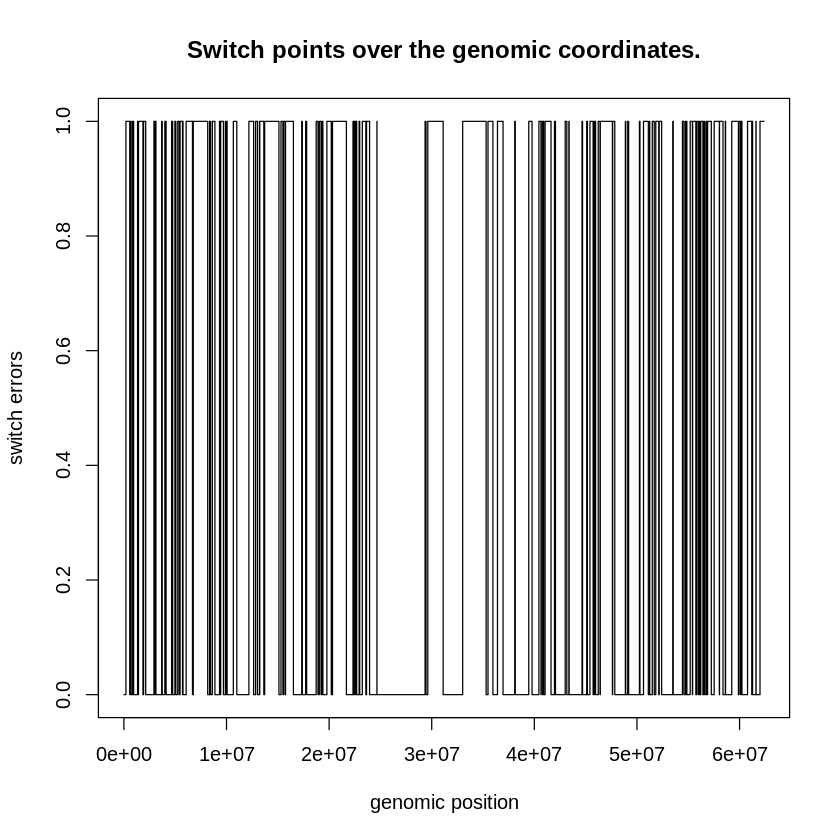

In [64]:
# png("data/SwitchPoints_SetA_withOutHaplotypeBreaks.png", width = 1600, height = 600)
plot(merged.data$POS, merged.data$match, main = "Switch points over the genomic coordinates.", type = "s", 
     xlab = "genomic position", ylab = "switch errors")

In [65]:

# Compute switch error rates 
number_of_hets <- length(merged.data$match)
num_of_switch <- 0
prev_match <- merged.data$match[1]
for (item in merged.data$match){
  curr_match = item
  if (curr_match != prev_match){
    num_of_switch = num_of_switch + 1
    
    # reset the "previous match" value
    prev_match = curr_match}}

switch_err_rate = num_of_switch/(number_of_hets)
switch_err_rate

[1] 0.022036

In [66]:
## So, now we compute switch point by including changes in "PI" values.
# Now, the "switch points" are addressed when :
  # we see 0 -> 1, or when 1 -> 0 in the "match" data
  # PI of the haplotype block changes
    # ** So, now we need to account for the match and also for change in haplotype block index.

# the length (number of rows) of the dataframe
seq_len <- length(merged.data$match)
seq_len


[1] 9666

In [67]:
# set empty variables 
previous_match <- 0
hap_size <- 0
haplotype_sizes <- integer()  # to store the size of haplotype extended truly.
previous_pi <- 1 
haplotype_breaks <- integer()

In [68]:

# run a for loop to find switch points 
for (ith in c(1:seq_len)){
  current_match = merged.data$match[ith]
  current_pi = merged.data$phased.NA12891.PI[ith]
  if (previous_match == current_match & previous_pi == current_pi) {
    hap_size = hap_size + 1}
  else if (previous_match != current_match | previous_pi != current_pi) {
    # store the haplotype size of properly phased (extended) block
    haplotype_sizes <- c(haplotype_sizes, hap_size)
    hap_size <- 1}  # reset the haplotype size to 1
  
  # store the last haplotype size when the for loop reaches the end
  if (ith == seq_len){
    haplotype_sizes <- c(haplotype_sizes, hap_size)}
  
  # also find the genomic positions where haplotype breaks occur 
  if (previous_pi != current_pi){
    haplotype_breaks <- c(haplotype_breaks, merged.data$POS[ith])}
  
  # update the previous match and pi values for next for-loop 
  previous_match = current_match
  previous_pi = current_pi }

In [69]:

## Identify switch points and compute "switch error" rates. 
# the total number of haplotype blocks represent frequecy of switch points
freq_of_switch = length(haplotype_sizes)
total_possible_switch = sum(haplotype_sizes) # or number of hets site
haplotype_sizes

[1]  50  26  11   5  22  54  12   6   9  12  73  36   5   5  96  15  15  38
 [19]  36  16 102  26   5   7  51   8   7  46  27  30  67  38   4   8  10  11
 [37]  44   5  27  31  15  29  25   9  10   7  92  55   6   7   4  11 112  32
 [55]  13  21  23  21 120  24  33   9  31   5   6  10  30  43  11  19   5   5
 [73]  16  13  60  13  62  30  97  86  47  28 127  28  34  17  59  11   5  65
 [91]   8  78  17  56  36  49  47   8  14  32   6  90  36  62  24  67  17  91
[109]  30  62  10   5  20   9  15  35   9  85  17  80   5  18 182   5  98   8
[127]  16   9   4   5   8   4   6   4  23  11   7   7   9   5  30  12  13  53
[145]  67  24   7  31  30   8   5  43 184  11  41 130  30 179 121  35  20  24
[163]  79  58  13  42 129   3  42  11 108  11   4 184  17  42  10  41   9  23
[181]  13   5  72  43   6  13  16  10   5  85  11  61  12  25   5   7   6  37
[199]  82  19  46  22  47   8  10  20   8  19  41  30   8   8  63   5   9 127
[217]  72   5  37   4   5   7 102  32  15   7   5   8  15  18  23   7   8   4
[235]  28   5  36  27  76   8  12  22  61  19   6 183  53   7  14  11  15   5
[253]  25  96   4  33   7  10  51  14   8  58  22   6  19  33  10   5  25  32
[271]   7  14  24  20  33  50   6  38  12  34  28   8  55  10  33  57  19  22
[289] 121   5  27  10   7   8   4  54  22  15  88   4  12  34  27   5  25  21
[307]  59  14

In [70]:
# calculate switch error rate
switch_error_rate = (freq_of_switch/total_possible_switch)
switch_error_rate

[1] 0.03186427

In [71]:
## Now, add another column that represent the fully accounted haplotype switchpoints.
phase_state = 0
match_by_pi <- integer()
for (sizes in haplotype_sizes) {
  match_by_pi <- c(match_by_pi, rep(phase_state, sizes))
  
  # change the phase state for next loop
  if (phase_state == 0){
    phase_state = 1}
  else if (phase_state == 1){
    phase_state = 0} }

In [72]:

## add data "match02" to the dataframe
merged.data$match_by_pi <- match_by_pi


## Now, make switch points plot by accounting for the haplotype breaks. 
# for that we will create another column with updated matches between truth and phased haplotypes

png 
  3

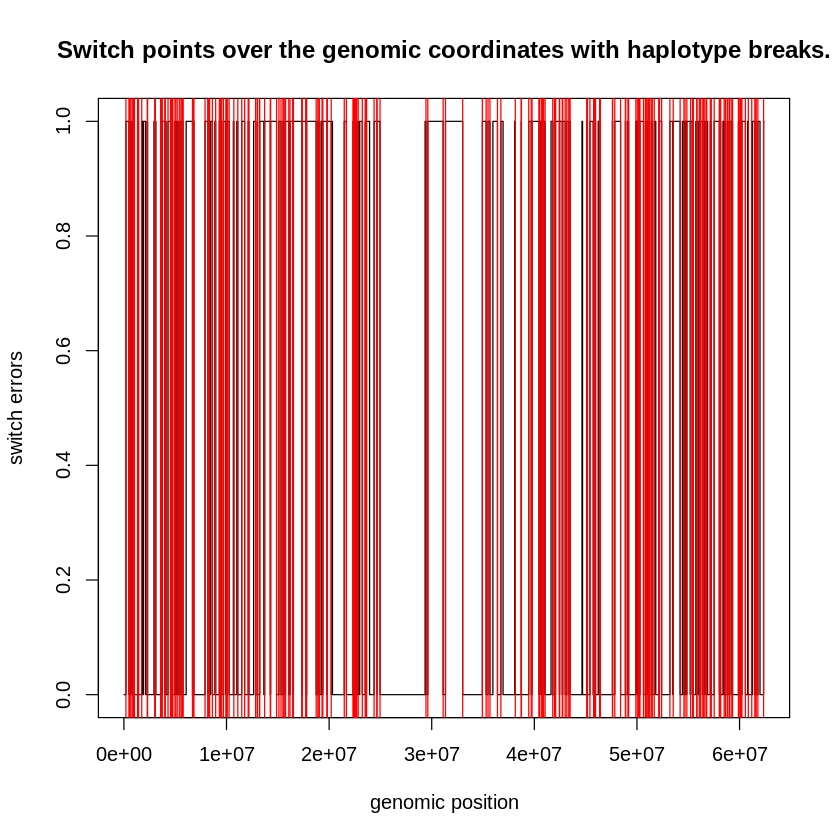

In [73]:
plot(merged.data$POS, merged.data$match_by_pi, main = "Switch points over the genomic coordinates with haplotype breaks.", type = "s", 
     xlab = "genomic position", ylab = "switch errors")
abline(v=haplotype_breaks, col='red')
dev.off()

## We can now overlay the haplotype breaks position on the top of switch points plot for convenience let's convert this haplotype size list into integer array

In [74]:
haplotype_size_numeric <- as.numeric(unlist(haplotype_sizes))
haplotype_size_numeric

[1]  50  26  11   5  22  54  12   6   9  12  73  36   5   5  96  15  15  38
 [19]  36  16 102  26   5   7  51   8   7  46  27  30  67  38   4   8  10  11
 [37]  44   5  27  31  15  29  25   9  10   7  92  55   6   7   4  11 112  32
 [55]  13  21  23  21 120  24  33   9  31   5   6  10  30  43  11  19   5   5
 [73]  16  13  60  13  62  30  97  86  47  28 127  28  34  17  59  11   5  65
 [91]   8  78  17  56  36  49  47   8  14  32   6  90  36  62  24  67  17  91
[109]  30  62  10   5  20   9  15  35   9  85  17  80   5  18 182   5  98   8
[127]  16   9   4   5   8   4   6   4  23  11   7   7   9   5  30  12  13  53
[145]  67  24   7  31  30   8   5  43 184  11  41 130  30 179 121  35  20  24
[163]  79  58  13  42 129   3  42  11 108  11   4 184  17  42  10  41   9  23
[181]  13   5  72  43   6  13  16  10   5  85  11  61  12  25   5   7   6  37
[199]  82  19  46  22  47   8  10  20   8  19  41  30   8   8  63   5   9 127
[217]  72   5  37   4   5   7 102  32  15   7   5   8  15  18  23   7   8   4
[235]  28   5  36  27  76   8  12  22  61  19   6 183  53   7  14  11  15   5
[253]  25  96   4  33   7  10  51  14   8  58  22   6  19  33  10   5  25  32
[271]   7  14  24  20  33  50   6  38  12  34  28   8  55  10  33  57  19  22
[289] 121   5  27  10   7   8   4  54  22  15  88   4  12  34  27   5  25  21
[307]  59  14

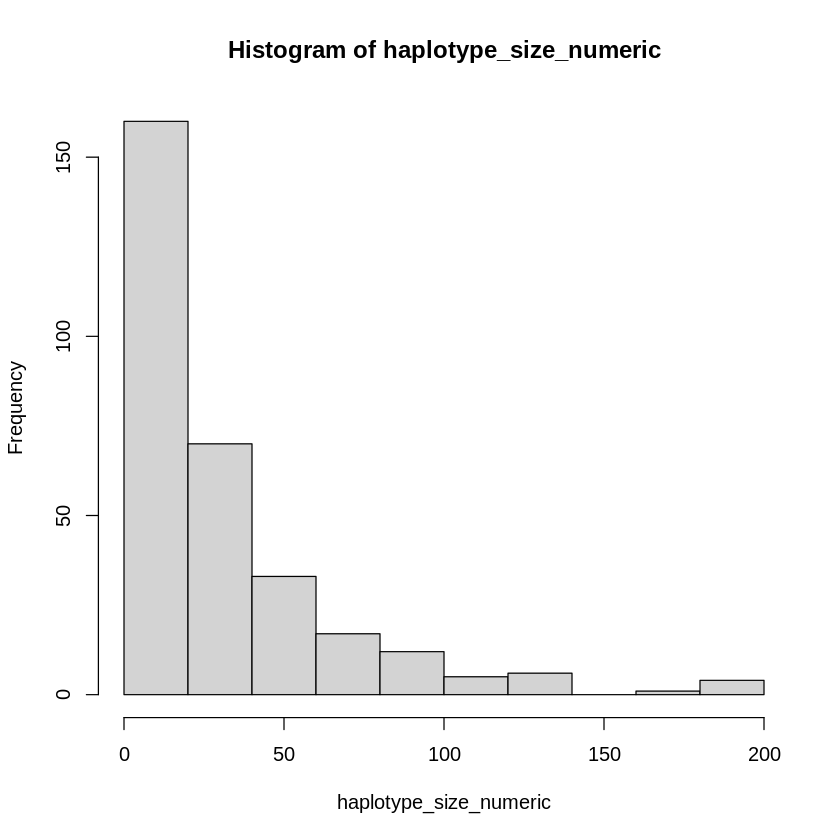

png 
  3

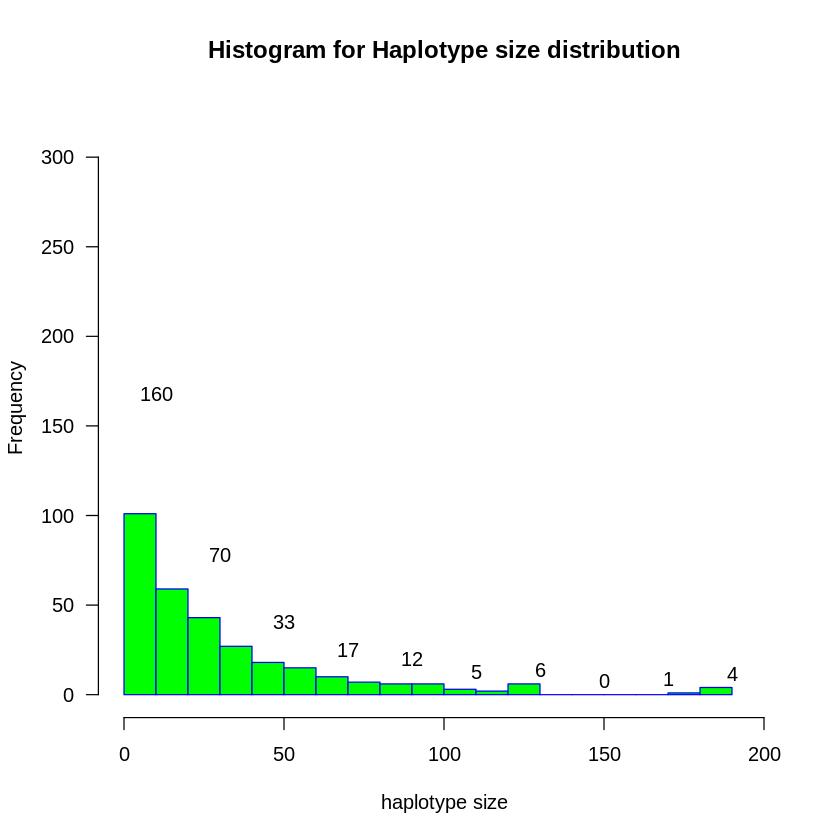

In [76]:
## Let's plot a histogram of the haplotype size distribution 
hisHap <- hist(haplotype_size_numeric)  # general histogram metrics for the data 
# png("data/rplots/Histogram_ofHaplotypeSizeDistribution_SetA.png", width = 1600, height = 600)
hist(haplotype_size_numeric, 
     main="Histogram for Haplotype size distribution", 
     xlab="haplotype size", 
     border="blue", 
     col="green",
     xlim=c(0,200),
     ylim = c(0,320),
     las=1, 
     breaks=20)
# add the size of the frequency to the histogram plot 
text(hisHap$mids,hisHap$counts,labels=hisHap$counts, adj=c(0.5, -0.5))
dev.off()

png 
  3

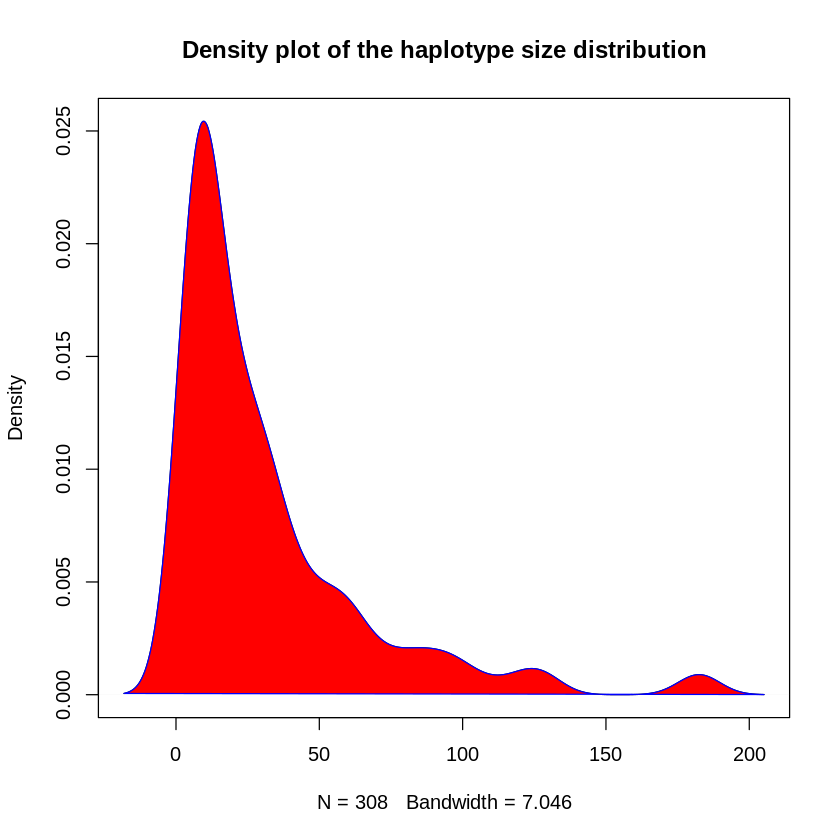

In [78]:
## Density plot
densHap <- density(haplotype_size_numeric)
# png("data/rplots/DensityPlot_ofHaplotypeSizeDistribution_SetA.png", width = 1600, height = 600)
plot(densHap, main = "Density plot of the haplotype size distribution")
polygon(densHap, col = 'red', border = 'blue')
dev.off()

# print("Completed the switch error analyses on first round of phaseExtension on Set-A data.")